In [17]:
%load_ext autoreload
%autoreload 2
import extract_environment as ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dir_env = '/home/kbrennan/phd/data/climate/present'
dir_track = '/home/kbrennan/phd/data/climate/tracks/present'
day = '20210628'

now = pd.to_datetime(day+'12', format='%Y%m%d%H')

In [3]:
cells = ee.load_cells(dir_track, day)

In [4]:
cell = cells[3]
cell['datelist']

[Timestamp('2021-06-28 10:40:00'),
 Timestamp('2021-06-28 10:45:00'),
 Timestamp('2021-06-28 10:50:00'),
 Timestamp('2021-06-28 10:55:00'),
 Timestamp('2021-06-28 11:00:00'),
 Timestamp('2021-06-28 11:05:00'),
 Timestamp('2021-06-28 11:10:00'),
 Timestamp('2021-06-28 11:15:00'),
 Timestamp('2021-06-28 11:20:00'),
 Timestamp('2021-06-28 11:25:00'),
 Timestamp('2021-06-28 11:30:00'),
 Timestamp('2021-06-28 11:35:00'),
 Timestamp('2021-06-28 11:40:00'),
 Timestamp('2021-06-28 11:45:00'),
 Timestamp('2021-06-28 11:50:00'),
 Timestamp('2021-06-28 11:55:00'),
 Timestamp('2021-06-28 12:00:00'),
 Timestamp('2021-06-28 12:05:00'),
 Timestamp('2021-06-28 12:10:00'),
 Timestamp('2021-06-28 12:15:00'),
 Timestamp('2021-06-28 12:20:00'),
 Timestamp('2021-06-28 12:25:00'),
 Timestamp('2021-06-28 12:30:00'),
 Timestamp('2021-06-28 12:35:00'),
 Timestamp('2021-06-28 12:40:00'),
 Timestamp('2021-06-28 12:45:00'),
 Timestamp('2021-06-28 12:50:00'),
 Timestamp('2021-06-28 12:55:00'),
 Timestamp('2021-06-

In [5]:
env = ee.load_environments(dir_env, now)

In [6]:
cookie = ee.cutout_cookie(cell, env, now)
cookie

<xarray.Dataset>
Dimensions:    (x: 51, y: 51, pressure: 8)
Coordinates:
  * x          (x) float64 -55.0 -52.8 -50.6 -48.4 -46.2 ... 48.4 50.6 52.8 55.0
  * y          (y) float64 -55.0 -52.8 -50.6 -48.4 -46.2 ... 48.4 50.6 52.8 55.0
    time       datetime64[ns] 2021-06-28T12:00:00
  * pressure   (pressure) float32 200.0 300.0 400.0 500.0 ... 700.0 850.0 925.0
Data variables: (12/59)
    U_10M      (y, x) float32 ...
    V_10M      (y, x) float32 ...
    VMAX_10M   (y, x) float32 ...
    T_2M       (y, x) float32 ...
    TD_2M      (y, x) float32 ...
    RELHUM_2M  (y, x) float32 ...
    ...         ...
    TOT_SNOW   (y, x) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    DHAIL_MX   (y, x) float32 dask.array<chunksize=(51, 51), meta=np.ndarray>
    rlat       (y) float32 2.66 2.68 2.7 2.72 2.74 ... 3.58 3.6 3.62 3.64 3.66
    rlon       (x) float32 -0.18 -0.16 -0.14 -0.12 -0.1 ... 0.76 0.78 0.8 0.82
    lat        (y, x) float32 49.66 49.66 49.66 49.66 ... 50.65 50.65 50.65
    lon        (y, x) float32 9.722 9.753 9.784 9.815 ... 11.2 11.23 11.26 11.29
Attributes:
    title:           COSMO driven by ERA5
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-09-29 12:24:34

In [7]:
u_storm = np.nanmean(cell["delta_y"][1::])
v_storm = np.nanmean(cell["delta_x"][1::])

In [8]:
cookie = ee.add_secondary_variables(cookie)
cookie

<xarray.Dataset>
Dimensions:     (pressure: 8, x: 51, y: 51)
Coordinates:
  * pressure    (pressure) float32 200.0 300.0 400.0 500.0 ... 700.0 850.0 925.0
  * x           (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y           (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
    time        datetime64[ns] 2021-06-28T12:00:00
Data variables: (12/67)
    U_10M       (y, x) float32 2.632 2.862 2.874 ... -0.3076 -0.4001 -0.3467
    V_10M       (y, x) float32 -3.148 -2.995 -3.428 ... -0.4536 0.6344 1.86
    VMAX_10M    (y, x) float32 8.977 8.465 9.32 10.28 ... 4.039 2.81 3.386 5.205
    T_2M        (y, x) float32 295.1 294.8 295.0 295.0 ... 299.2 297.5 297.4
    TD_2M       (y, x) float32 290.8 290.8 290.5 290.0 ... 291.3 291.7 290.7
    RELHUM_2M   (y, x) float32 76.64 78.09 75.47 73.38 ... 61.91 69.77 66.21
    ...          ...
    THETA       (pressure, y, x) float32 343.1 343.0 342.8 ... 301.0 301.1 301.0
    THETA_2M    (y, x) float32 296.8 296.7 297.0 296.9 ... 302.5 300.8 300.3
    THETA_E     (pressure, y, x) float32 343.2 343.1 343.0 ... 336.8 336.6 334.0
    THETA_E_2M  (y, x) float32 334.8 334.7 334.5 333.1 ... 343.4 342.3 339.2
    VORT        (pressure, y, x) float64 0.02336 0.05871 0.07448 ... 1.609 1.366
    DIV         (pressure, y, x) float64 -0.08512 -0.04551 ... -0.5471 0.1059
Attributes:
    title:           COSMO driven by ERA5
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-09-29 12:24:34

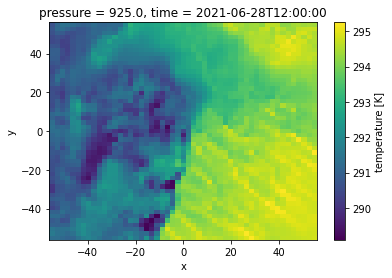

In [9]:
cookie.T.sel(pressure=925).plot()

In [10]:
cookie['U'] = cookie['U'] *0
cookie['V'] = cookie['V'] *0+5

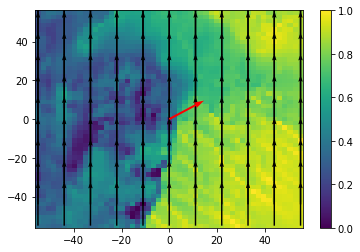

In [11]:
pressure = 925
plt.pcolormesh(cookie.x,cookie.y,cookie.T.sel(pressure=pressure))
stride= 5
plt.quiver(cookie.x[::stride],cookie.y[::stride],cookie.U.sel(pressure=pressure)[::stride,::stride],cookie.V.sel(pressure=pressure)[::stride,::stride], scale=30)
plt.quiver(0,0,u_storm,v_storm, scale=10, color='r')
plt.colorbar()

In [12]:
r_cookie = ee.rotate_cookie(cookie,cell)

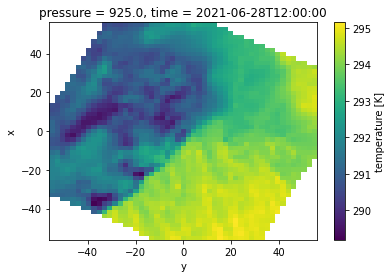

In [13]:
r_cookie.T.sel(pressure=925).plot()

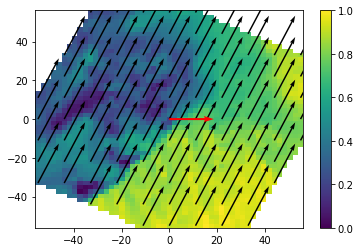

In [14]:
pressure = 925
plt.pcolormesh(r_cookie.x,r_cookie.y,r_cookie.T.sel(pressure= pressure))
stride= 5
plt.quiver(cookie.x[::stride],r_cookie.y[::stride],r_cookie.U.sel(pressure=pressure)[::stride,::stride],r_cookie.V.sel(pressure=pressure)[::stride,::stride], scale=30)
plt.quiver(0,0,5,0, scale=30, color='r')
plt.colorbar()

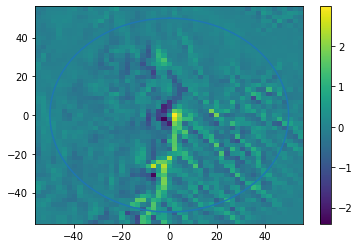

In [15]:
plt.pcolormesh(cookie.x,cookie.y,cookie.W.sel(pressure=925).squeeze())
# plot circle
circle = plt.plot(np.sin(np.linspace(0,2*np.pi,100))*50,np.cos(np.linspace(0,2*np.pi,100))*50)
plt.colorbar()